### Задание
1) Найти данные для задачи классификации или для задачи регрессии.

2) Реализовать бэггинг.

3) Реализовать бустинг на тех же данных, что использовались для баггинга.

4) Сравнить результаты работы алгоритмов (время работы и качество моделей). Сделать выводы.

## Импорт библиотек

In [1]:
pip install --quiet datatable

In [5]:
pip install --quiet imbalanced-learn==0.9.1

In [3]:
pip install --quiet catboost

In [6]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import fbeta_score, classification_report, precision_recall_curve

import imblearn
from imblearn.metrics import geometric_mean_score
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

from datatable import fread
import warnings
warnings.filterwarnings('ignore')

In [7]:
imblearn.__version__

'0.9.1'

In [9]:
import catboost
catboost.__version__

'1.1.1'

## Предобработка данных

In [8]:
url = 'stroke.zip/full_data.csv'
df = fread(url)
df = df.to_pandas()
print(df.shape)
df.head(3)

(4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
1,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
2,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True


**Описание столбцов**

    gender:            "Male", "Female" or "Other"

    age:               age of the patient

    hypertension:      0 if the patient doesn't have hypertension, 1 if the patient has hypertension

    heartdisease:      0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
    
    evermarried:       "No" or "Yes"

    worktype:          "children", "Govtjov", "Neverworked", "Private" or "Self-employed"

    Residencetype:     "Rural" or "Urban"

    avgglucoselevel:   average glucose level in blood

    bmi:               body mass index

    smoking_status:    "formerly smoked", "never smoked", "smokes" or "Unknown"*

    stroke:            1 if the patient had a stroke or 0 if not

In [10]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
df.duplicated().any()

False

In [12]:
df.nunique()

gender                  2
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               4
Residence_type          2
avg_glucose_level    3895
bmi                   342
smoking_status          4
stroke                  2
dtype: int64

In [13]:
df.dtypes

gender                object
age                  float64
hypertension            bool
heart_disease           bool
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                  bool
dtype: object

## Разведочный анализ данных (EDA)

In [14]:
# Смотрим на баланс классов
df.stroke.value_counts()

False    4733
True      248
Name: stroke, dtype: int64

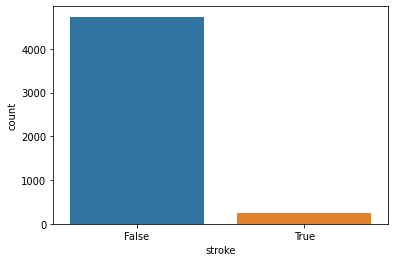

In [15]:
# Датасет несбалансирован
sns.countplot(data=df, x='stroke');

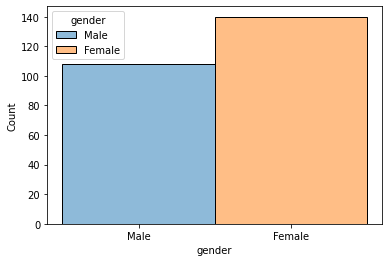

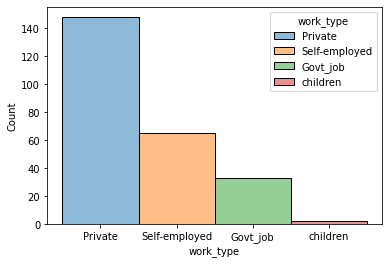

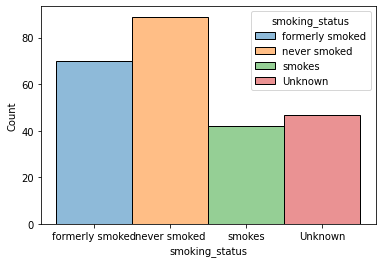

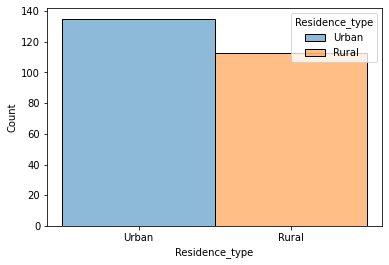

In [16]:
features = ['gender', 'work_type', 'smoking_status', 'Residence_type']

for feature in features:
    sns.histplot(data=df.loc[df.stroke == True], x=feature, hue=feature)
    plt.show()

Чаще рак встречался у женщин.

In [17]:
cm = sns.light_palette("green", as_cmap=True)
df.describe().T.sort_values(ascending=False, by="mean").style\
.background_gradient(cmap=cm).set_precision(2)\
.highlight_min(axis=1, color='#7DB0A8')\
.highlight_max(axis=1, color='#c2b280')

,count,mean,std,min,25%,50%,75%,max
avg_glucose_level,4981.00,105.94,45.08,55.12,77.23,91.85,113.86,271.74
age,4981.00,43.42,22.66,0.08,25.00,45.00,61.00,82.00
bmi,4981.00,28.50,6.79,14.00,23.70,28.10,32.60,48.90


In [18]:
df = pd.get_dummies(df, columns = ['work_type', 'smoking_status'])
df['gender'] = [1 if i == 'Male' else 0 for i in df['gender']]
df['ever_married'] = [ 1 if i =='Yes' else 0 for i in df['ever_married'] ]
df['Residence_type'] = [ 1 if i =='Urban' else 0 for i in df['Residence_type'] ]
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,False,True,1,1,228.69,36.6,True,0,1,0,0,0,1,0,0
1,1,80.0,False,True,1,0,105.92,32.5,True,0,1,0,0,0,0,1,0
2,0,49.0,False,False,1,1,171.23,34.4,True,0,1,0,0,0,0,0,1


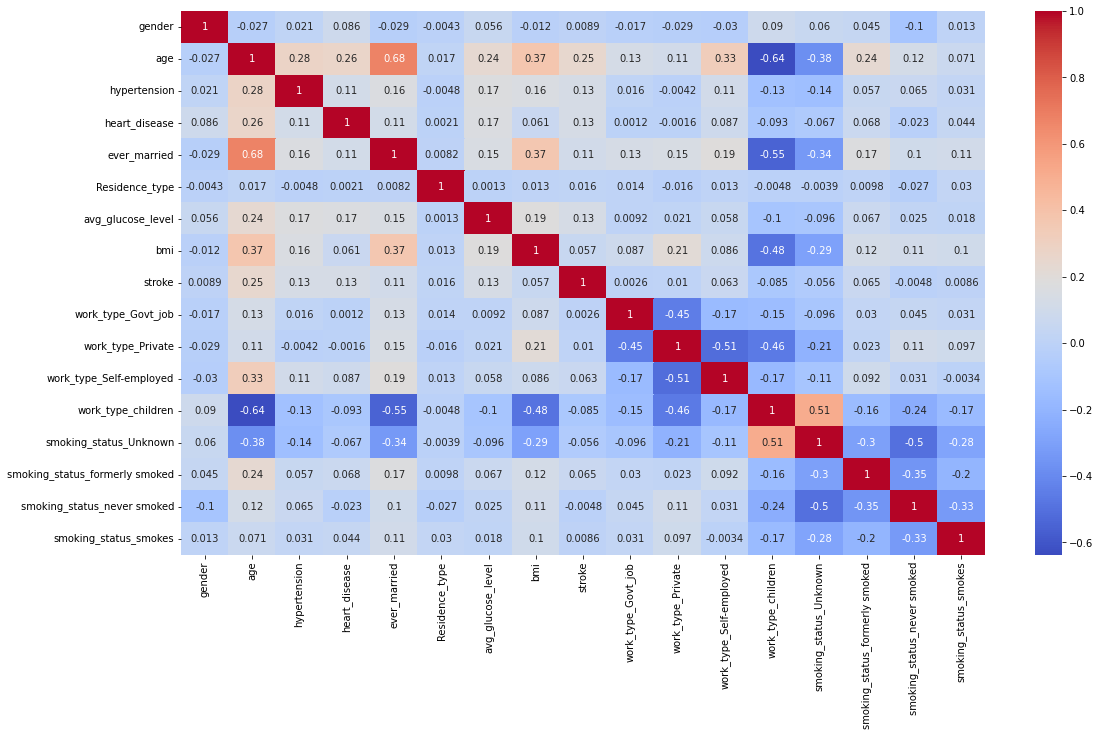

In [19]:
plt.figure(figsize=(18, 10))
# fig.set_dpi(150)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## Разделение на train, text

In [20]:
X = df.loc[:, df.columns != 'stroke']
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [21]:
RANDOM_STATE = 42

В задаче предсказания инсульта точность (Precision) показывает, сколько из случаев, определенных как инсульт, действительно являются таковыми, а полнота – какую долю инсультов нам удалось выявить.

Соотвественно, необходимо минимизировать точность, то есть снизить долю тех предсказаний, когда алгоритм не выявил инсульт при его наличии. Для этого $β$ надо поставить больше 1 при проверке качества классификатора.



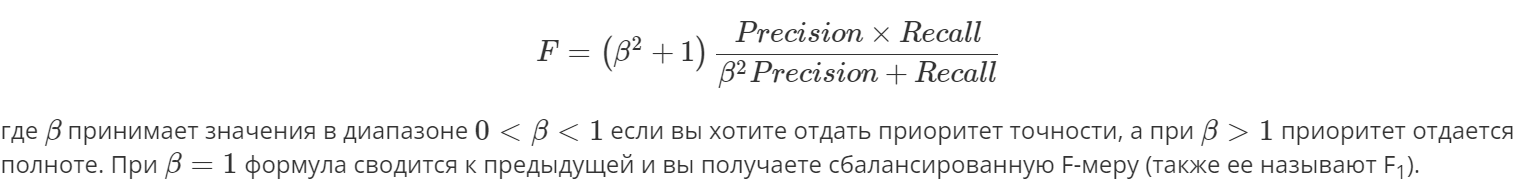

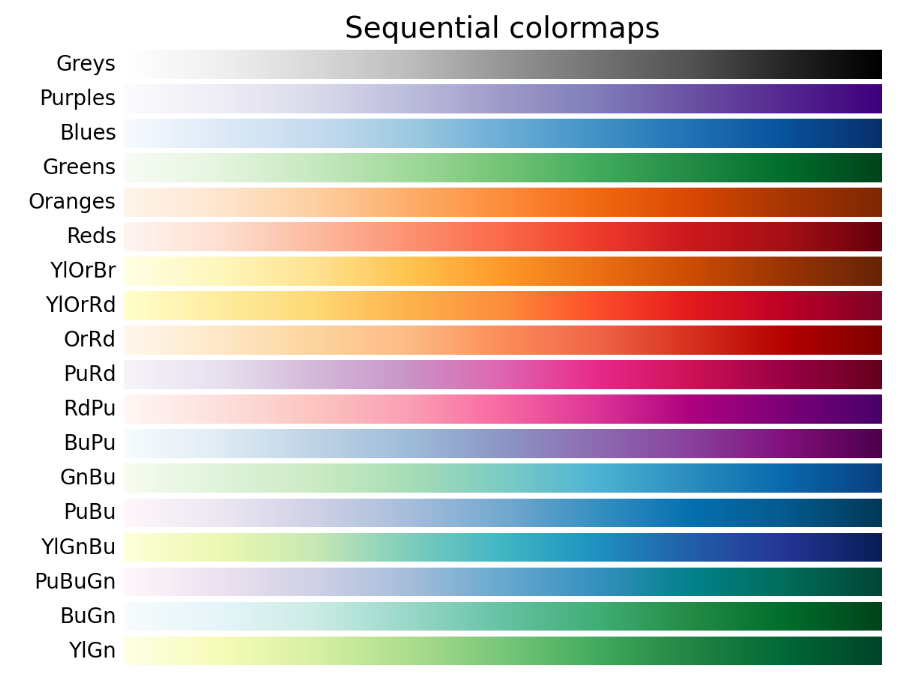

## Bagging

### BaggingClassifier

In [22]:
tree = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
bagging_clf = BaggingClassifier(base_estimator=tree, n_estimators=15,
                                max_samples=5, random_state=RANDOM_STATE)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=42),
                  max_samples=5, n_estimators=15, random_state=42)

In [23]:
predicted_y_bagCl = bagging_clf.predict(X_test)

In [24]:
print(classification_report(y_test, predicted_y_bagCl))

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       947
        True       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.93       997



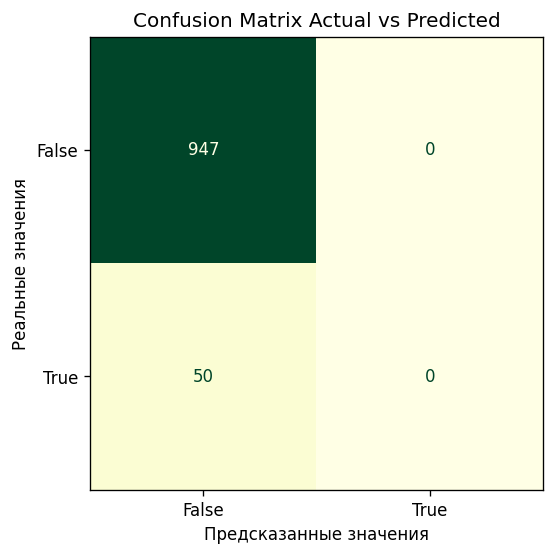

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(120)
plot_confusion_matrix(bagging_clf, X_test, y_test, ax=ax, cmap=plt.cm.YlGn, colorbar=False)
ax.set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Confusion Matrix Actual vs Predicted')
plt.show()

In [26]:
fbeta_score(y_test, predicted_y_bagCl, average='macro', beta=2)

0.49477533960292575

In [27]:
bagging_balanced_clf = BalancedBaggingClassifier(base_estimator=tree, n_estimators=13, random_state=RANDOM_STATE)
bagging_balanced_clf.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                random_state=42),
                          n_estimators=13, random_state=42)

In [28]:
predicted_y_bagCl_balanced = bagging_balanced_clf.predict(X_test)

In [29]:
print("Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, predicted_y_bagCl):.4f} - "
    f"Geometric mean {geometric_mean_score(y_test, predicted_y_bagCl):.4f}"
)
print("Balanced Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, predicted_y_bagCl_balanced):.4f} - "
    f"Geometric mean {geometric_mean_score(y_test, predicted_y_bagCl_balanced):.4f}"
)

Bagging classifier performance:
Balanced accuracy: 0.5000 - Geometric mean 0.0000
Balanced Bagging classifier performance:
Balanced accuracy: 0.7712 - Geometric mean 0.7706


In [30]:
print(classification_report(y_test, predicted_y_bagCl_balanced))

              precision    recall  f1-score   support

       False       0.99      0.74      0.85       947
        True       0.14      0.80      0.24        50

    accuracy                           0.75       997
   macro avg       0.56      0.77      0.54       997
weighted avg       0.94      0.75      0.82       997



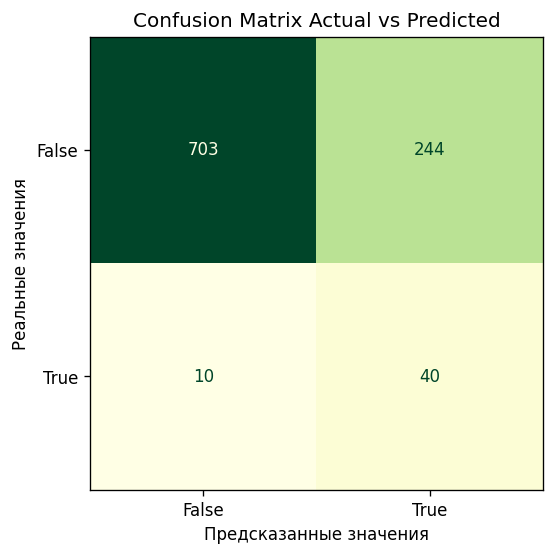

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(120)
plot_confusion_matrix(bagging_balanced_clf, X_test, y_test, ax=ax, cmap=plt.cm.YlGn, colorbar=False)
ax.set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Confusion Matrix Actual vs Predicted')
plt.show()

In [32]:
fbeta_score(y_test, predicted_y_bagCl_balanced, average='macro', beta=2)

0.5970803549624418

### RandomForestClassifier

In [33]:
rf = RandomForestClassifier(n_estimators=20, random_state=RANDOM_STATE)
brf = BalancedRandomForestClassifier(n_estimators=30, random_state=RANDOM_STATE)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred_rf))
print('-------------------------------------------------------')
print(classification_report(y_test, y_pred_brf))

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       947
        True       0.50      0.02      0.04        50

    accuracy                           0.95       997
   macro avg       0.73      0.51      0.51       997
weighted avg       0.93      0.95      0.93       997

-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.99      0.73      0.84       947
        True       0.14      0.86      0.25        50

    accuracy                           0.73       997
   macro avg       0.57      0.79      0.54       997
weighted avg       0.95      0.73      0.81       997



In [35]:
print("Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rf):.4f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_rf):.4f}"
)
print("Balanced Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_brf):.4f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_brf):.4f}"
)

Random Forest classifier performance:
Balanced accuracy: 0.5095 - Geometric mean 0.1413
Balanced Random Forest classifier performance:
Balanced accuracy: 0.7938 - Geometric mean 0.7910


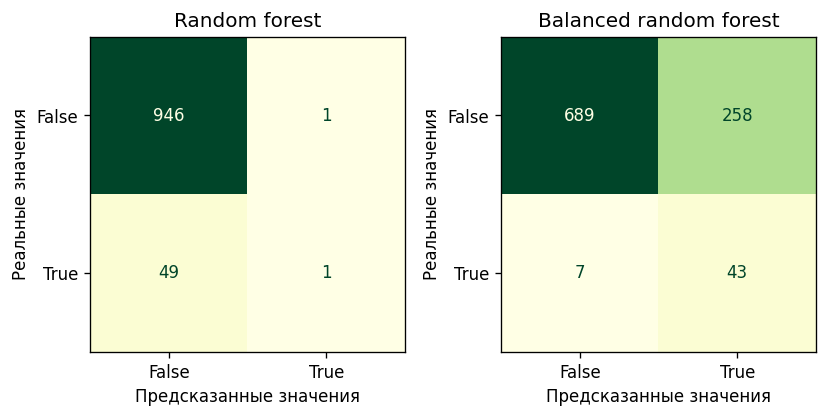

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 4))
fig.set_dpi(120)
plot_confusion_matrix(rf, X_test, y_test, ax=axs[0], colorbar=False, cmap=plt.cm.YlGn)
axs[0].set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Random forest')

plot_confusion_matrix(brf, X_test, y_test, ax=axs[1], colorbar=False, cmap=plt.cm.YlGn)
axs[1].set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Balanced random forest')

fig.tight_layout()

### Using gridsearch

In [37]:
brf_new = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

In [38]:
params_grid = {
    'n_estimators': [10, 50],
    'max_depth': [10, 15],
    'min_samples_leaf': [4, 6],
    'min_samples_split': [4, 6]
}

grid_search_rfb = GridSearchCV(estimator=brf_new, param_grid=params_grid,
                               scoring='f1_macro', cv=4)

In [39]:
grid_search_rfb.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=BalancedRandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6],
                         'n_estimators': [10, 50]},
             scoring='f1_macro')

In [40]:
best_model = grid_search_rfb.best_estimator_
best_model

BalancedRandomForestClassifier(max_depth=15, min_samples_leaf=4,
                               min_samples_split=4, n_estimators=50,
                               random_state=42)

In [41]:
y_pred_rbf_best = best_model.predict(X_test)

In [42]:
print("Balanced Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rbf_best):.4f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_rbf_best):.4f}"
)

Balanced Random Forest classifier performance:
Balanced accuracy: 0.8074 - Geometric mean 0.8021


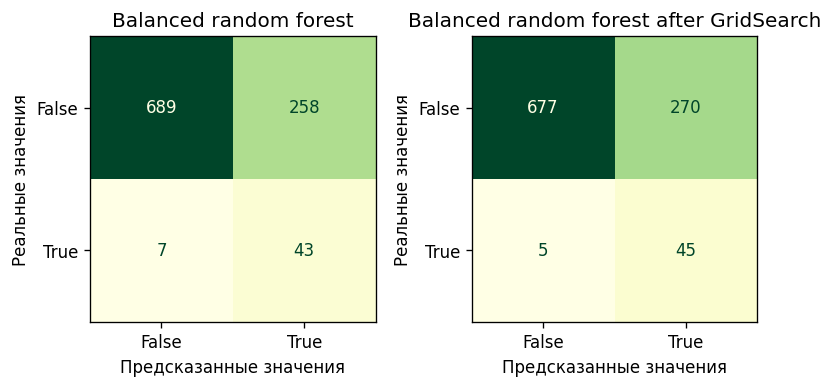

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 4))
fig.set_dpi(120)
plot_confusion_matrix(brf, X_test, y_test, ax=axs[0], colorbar=False, cmap=plt.cm.YlGn)
axs[0].set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Balanced random forest')

plot_confusion_matrix(best_model, X_test, y_test, ax=axs[1], colorbar=False, cmap=plt.cm.YlGn)
axs[1].set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Balanced random forest after GridSearch')

fig.tight_layout()

In [44]:
fbeta_score(y_test, y_pred_rbf_best, average='macro', beta=2)

0.5970819486978995

## Boosting

### CatBoost

In [39]:
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, task_type='GPU', devices='0')
cat_model.fit(X_train, y_train)

Learning rate set to 0.031243
0:	learn: 0.6388873	total: 66.7ms	remaining: 1m 6s
1:	learn: 0.5968559	total: 245ms	remaining: 2m 2s
2:	learn: 0.5539274	total: 321ms	remaining: 1m 46s
3:	learn: 0.5223460	total: 352ms	remaining: 1m 27s
4:	learn: 0.4849305	total: 376ms	remaining: 1m 14s
5:	learn: 0.4589647	total: 395ms	remaining: 1m 5s
6:	learn: 0.4349344	total: 534ms	remaining: 1m 15s
7:	learn: 0.4149602	total: 577ms	remaining: 1m 11s
8:	learn: 0.3937838	total: 642ms	remaining: 1m 10s
9:	learn: 0.3757873	total: 710ms	remaining: 1m 10s
10:	learn: 0.3559247	total: 811ms	remaining: 1m 12s
11:	learn: 0.3411596	total: 849ms	remaining: 1m 9s
12:	learn: 0.3252414	total: 988ms	remaining: 1m 14s
13:	learn: 0.3107620	total: 1.06s	remaining: 1m 14s
14:	learn: 0.2998017	total: 1.13s	remaining: 1m 14s
15:	learn: 0.2899661	total: 1.19s	remaining: 1m 13s
16:	learn: 0.2789647	total: 1.42s	remaining: 1m 22s
17:	learn: 0.2687159	total: 1.51s	remaining: 1m 22s
18:	learn: 0.2606214	total: 1.65s	remaining: 1m

In [45]:
y_pred_catboost = cat_model.predict(X_test, task_type='GPU')

In [57]:
y_pred_catboost = [False if i=='False' else True for i in y_pred_catboost]
for i in y_pred_catboost:
  if i==True:
    print(i)

True
True


In [58]:
print(f'Classification Report \n\n{classification_report(y_test, y_pred_catboost)}')

Classification Report 

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       947
        True       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.92       997



In [60]:
y_test_cat = ['False' if i==False else 'True' for i in y_test]

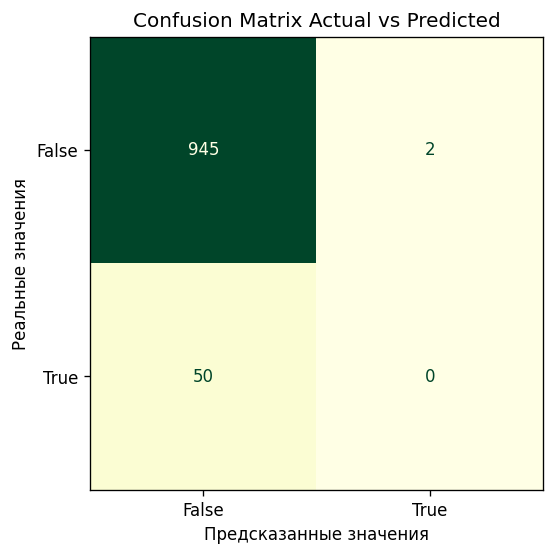

In [61]:
fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(120)
plot_confusion_matrix(cat_model, X_test, y_test_cat, ax=ax, cmap=plt.cm.YlGn, colorbar=False)
ax.set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Confusion Matrix Actual vs Predicted')
plt.show()

### XGBoost, LGBM

In [72]:
xgb_model = XGBClassifier(random_state=RANDOM_STATE, task_type='GPU', devices='0')
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE)

In [84]:
def fine_tune(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error',
                               return_train_score=True)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, np.sqrt((-1)*grid_search.best_score_)

In [85]:
param_grid_1 = [{'n_estimators': [20, 40, 60, 80, 100], 'max_depth': [2, 4, 6, 8], 'max_leaves': [50, 100, 200]}]
param_grid_2 = [{'n_estimators': [20, 40, 60, 80, 100], 'max_depth': [2, 3, 4, 6, 8], 'num_leaves': [50, 100, 200]}]

a = fine_tune(xgb_model, param_grid_1, X_train, y_train)
b = fine_tune(lgbm_model, param_grid_2, X_train, y_train)

In [87]:
a[0]

{'max_depth': 2, 'max_leaves': 50, 'n_estimators': 20}

In [88]:
b[0]

{'max_depth': 2, 'n_estimators': 20, 'num_leaves': 50}

In [89]:
boost_model = XGBClassifier(max_depth=2, max_leaves=50, n_estimators=20)
boost_model.fit(X_train, y_train)

XGBClassifier(max_depth=2, max_leaves=50, n_estimators=20)

In [90]:
y_pred = boost_model.predict(X_test)

In [91]:
print(f'Classification Report \n\n{classification_report(y_test, y_pred)}')

Classification Report 

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       947
        True       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.93       997



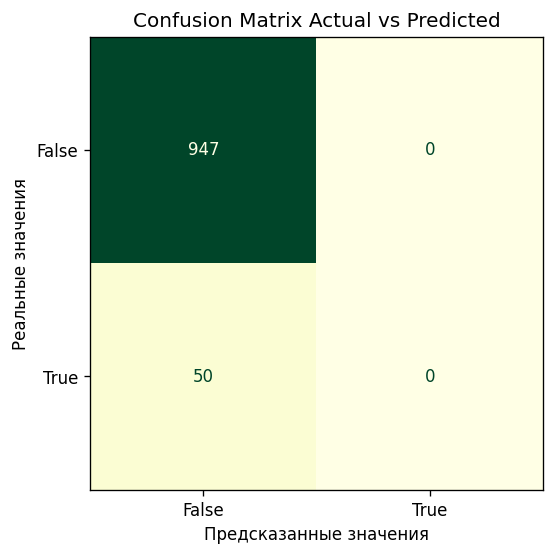

In [93]:
fig, ax = plt.subplots(figsize=(5,5))
fig.set_dpi(120)
plot_confusion_matrix(boost_model, X_test, y_test, ax=ax, cmap=plt.cm.YlGn, colorbar=False)
ax.set(xlabel='Предсказанные значения', ylabel='Реальные значения', title='Confusion Matrix Actual vs Predicted')
plt.show()

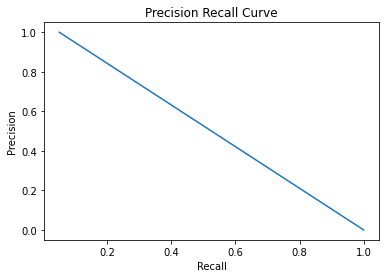

In [92]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(lr_precision, lr_recall)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision Recall Curve')
plt.show()